# terms
$\Lambda$ : Hyperparameter \
$\theta$ : Param of single distribution \
$\mu$ : Mean of the distribution \
$\sigma$ : variance of distribution \
$X$ : DATA \
$Z$: Evidence

For changing distribution of $\lambda$ https://docs.scipy.org/doc/scipy/reference/stats.html

Some helpful resources : https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html, https://docs.exoplanet.codes/en/latest/tutorials/intro-to-pymc3/, https://boyangzhao.github.io/posts/mcmc-bayesian-inference


Solving $ P(\Lambda|X,\mu)$ using Bayes th. 

$ P(\Lambda|X,\mu) =\frac{P(X,\mu|\Lambda)\pi(\Lambda)}{Z}=\frac{P(X|\mu,\Lambda)\pi(\mu|\Lambda)\pi(\Lambda)}{Z}$

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import arviz as az

# Case 1 : $\Lambda$ is a Gaussian

Text(0.5, 1.0, 'PDF$(\\Lambda)=\\mathcal{N}(3,1)$')

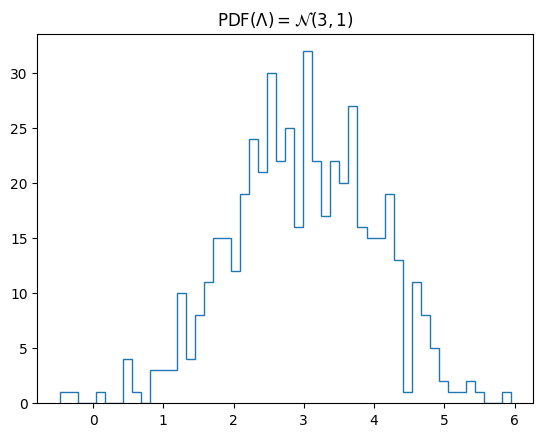

In [10]:
LEN_DATA = 500 # size of X
LEN_HYPERPARAM = 500 # mu in this case 
LAMBDA = st.norm(loc=3, scale=1).rvs(size=LEN_HYPERPARAM) # hyperparameter is governed by a gaussian function

plt.hist(LAMBDA, bins=50, fill=False, histtype='step')
plt.title(r'PDF$(\Lambda)=\mathcal{N}(3,1)$')

In [11]:
X = np.empty((LEN_HYPERPARAM, LEN_DATA))
for i in range(LEN_HYPERPARAM):
    
    # Note here the std. dev of the X's is small. Large std. dev would lead
    # to incorrect estimation of "MU". For eg. std. dev of 1 would lead to 
    # MU ~ 1.5.
    
    X[i] = st.norm(loc=LAMBDA[i], scale=.05).rvs(size=LEN_DATA) 

Text(0.5, 1.0, 'PDF$(X)=\\mathcal{N}(\\mu(\\Lambda),1)$')

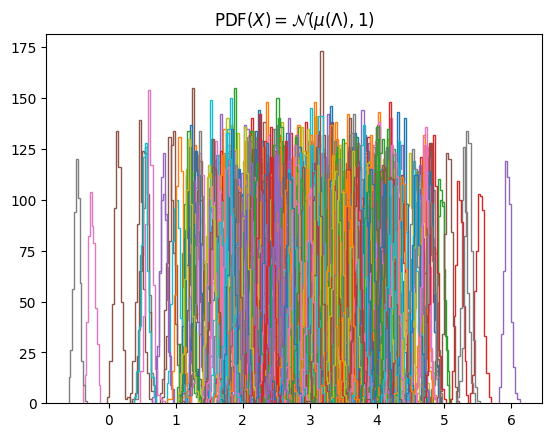

In [12]:
# large number of data sets can lead to a messy plot
for i in range(LEN_HYPERPARAM):
    plt.hist(X[i], fill=False, histtype='step', label=i)
#plt.legend()
plt.title(r'PDF$(X)=\mathcal{N}(\mu(\Lambda),1)$')

## USING MCMC (Metropolis Hasting algo)

In [13]:
import pymc3 as pm

In [14]:
with pm.Model() as model:

    hyperprior = pm.Normal('MU', mu=0, sigma=1)  # hyperprior
    prior = pm.Normal('mu', mu=hyperprior, sigma=.05)  # prior draws data points from hyperprior
    obs = pm.Normal('obs', mu=prior, sigma=1, observed=X)  # likelihood draws data points from prior
    step = pm.Metropolis()

    # sample with 3 independent Markov chains
    trace = pm.sample(draws=1000, chains=2, step=step, return_inferencedata=True)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [MU]


/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<Axes: title={'center': 'MU'}>, <Axes: title={'center': 'MU'}>]],
      dtype=object)

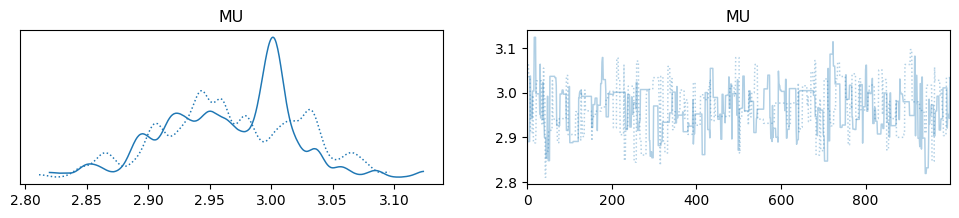

In [15]:
az.plot_trace(trace, var_names=('MU'))

In [16]:
az.summary(trace, var_names=["MU"])["mean"]

MU    2.966
Name: mean, dtype: float64

# Case 2: $\Lambda$ is a Linear

In [2]:
LEN_DATA = 500 # size of X
LEN_HYPERPARAM = 500 
A, B = 1, 2
LAMBDA = lambda x : A*x**B
X = np.empty((LEN_HYPERPARAM, LEN_DATA))

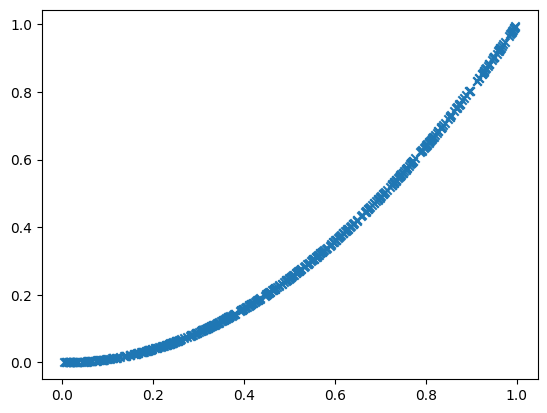

In [7]:
x = np.random.rand(LEN_HYPERPARAM)
plt.scatter(x, LAMBDA(x), marker='x')

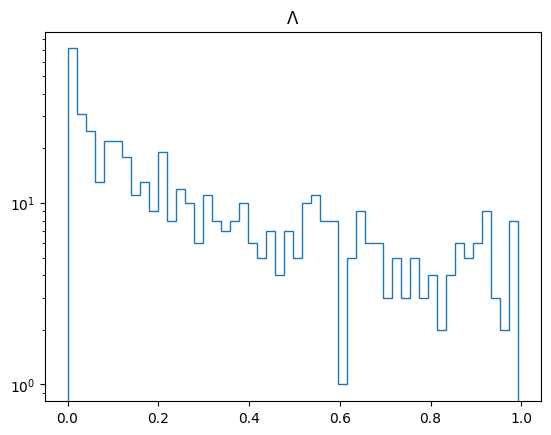

In [10]:
plt.hist(LAMBDA(x), bins=50, fill=False, histtype='step')
plt.title(r'$\Lambda$')
plt.yscale('log')

In [11]:
X = np.empty((LEN_HYPERPARAM, LEN_DATA))
for i in range(LEN_HYPERPARAM):
    X[i] = st.norm(loc=LAMBDA(x[i]), scale=1).rvs(size=LEN_DATA)

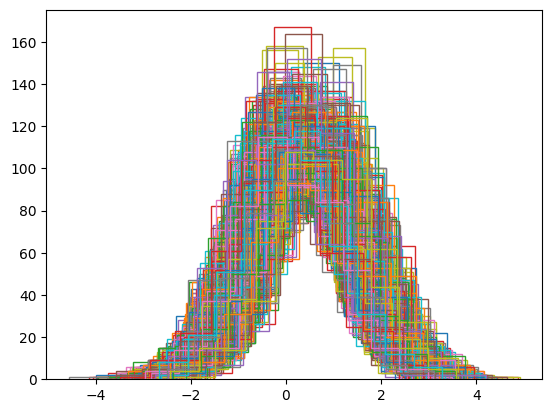

In [12]:
# large number of data sets can lead to a messy plot
for i in range(LEN_HYPERPARAM):
    plt.hist(X[i], fill=False, histtype='step', label=i)
#plt.legend()

In [13]:
import pymc3 as pm

In [15]:
with pm.Model() as model:
    
    A = pm.Uniform('A', lower=0, upper=5)
    B = pm.Uniform('B', lower=0, upper=5)
    hyperprior = pm.Normal('PL', mu=A*x**B, sigma=1)  # hyperprior
    prior = pm.Normal('mu', mu=hyperprior, sigma=1)  # prior draws data points from hyperprior
    obs = pm.Normal('obs', mu=prior, sigma=1, observed=X)  # likelihood draws data points from prior
    step = pm.Metropolis()
 
    # sample with 3 independent Markov chains
    trace = pm.sample(draws=1000, chains=3, step=step, return_inferencedata=True)

TypeError: Wrong number of dimensions: expected 0, got 1 with shape (500,).

array([[<Axes: title={'center': 'MU'}>, <Axes: title={'center': 'MU'}>]],
      dtype=object)

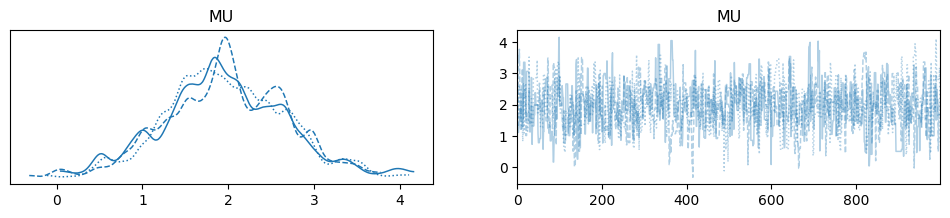

In [12]:
az.plot_trace(trace, var_names=('MU'))